In [1]:
import pennylane as qml

import numpy as np

from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'pennylane'

In [3]:
dev = qml.device("default.qubit", wires=2)

In [4]:
# Pauli matrices
Id = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

parameters = np.loadtxt("HamiltonianParameters.txt")

R = 90
H_param = parameters[parameters[:,0]==R,1:].flatten()

C = H_param[0]
Jx = H_param[1]
Jz = H_param[2]
#Jx = H_param[3]
Jxx = H_param[4]
Jxz = H_param[5]
#Jz = H_param[6]
#Jzx = H_param[7]
Jzz = H_param[8]

print(f"Jx={Jx}, Jz={Jz}, Jxx={Jxx}, Jzz={Jzz}, Jxz={Jxz}, C={C}")

def Hamiltonian():
    H = Jx * (np.kron(X,Id) + np.kron(Id,X))
    H = H + Jz * (np.kron(Z,Id) + np.kron(Id,Z))
    H = H + Jxx * np.kron(X,X)
    H = H + Jzz * np.kron(Z,Z)
    H = H + Jxz * (np.kron(X,Z) + np.kron(Z,X))
    H = H + C * np.kron(Id,Id)

    return H/2

def exactEnergy():
    H = Hamiltonian()

    E, V = np.linalg.eigh(H)
    return np.min(E)

print(f"Exact ground state energy is E = {exactEnergy()}")

Jx=-0.2288, Jz=-1.0466, Jxx=0.2613, Jzz=0.2356, Jxz=0.2288, C=-3.8505
Exact ground state energy is E = -2.8626207640766816


In [5]:
@qml.qnode(dev)
def ansatz(angles):
    theta = angles[:8]
    basis = angles[8:]  # basis has two elements with values 0 or 1

    # inital rotations
    qml.RX(theta[0], wires=0)
    qml.RZ(theta[1], wires=0)
    qml.RX(theta[2], wires=1)
    qml.RZ(theta[3], wires=1)

    # CNOT to entangle
    qml.CZ(wires=[0,1])

    # second round of rotations
    qml.RX(theta[4], wires=0)
    qml.RZ(theta[5], wires=0)
    qml.RX(theta[6], wires=1)
    qml.RZ(theta[7], wires=1)

    qml.U3(basis[0]*np.pi/2, 0, basis[0]*np.pi, wires=0)  # apply hadamard gate to qubit 0 iff basis[0]=1
    qml.U3(basis[1]*np.pi/2, 0, basis[1]*np.pi, wires=1)  # apply hadamard gate to qubit 1 iff basis[1]=1

    return qml.probs(wires=[0,1])

[0.16713867 0.38551025 0.1743042  0.27304688]


(<Figure size 900x300 with 1 Axes>, <Axes: >)

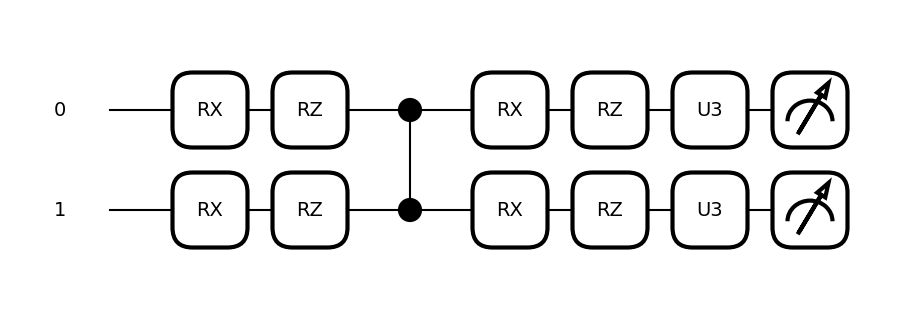

In [6]:
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))
angles = theta + [1,1]  # measure in XX basis
test_circuit = ansatz(angles, shots=81920)
print(test_circuit)

qml.drawer.use_style("black_white")
qml.draw_mpl(ansatz)(angles)  # plot the circuit diagram

In [7]:
def get_expectation(gate, probabilities):
    II = np.array([1,1,1,1])
    IZ = np.array([1,-1,1,-1])
    ZI = np.array([1,1,-1,-1])
    ZZ = np.array([1,-1,-1,1])
    
    probabilities = np.array(probabilities)

    if gate == 'II':
        return np.dot(II, probabilities)
    if gate == 'IZ' or gate == 'IX':
        return np.dot(IZ, probabilities)
    if gate == 'ZI' or gate == 'XI':
        return np.dot(ZI, probabilities)
    if gate == 'ZZ' or gate == 'XX' or gate == 'XZ' or gate == 'ZX':
        return np.dot(ZZ, probabilities)

    return 'Unidentified Gate'

In [8]:
def energy(probs_XX, probs_XZ, probs_ZX, probs_ZZ):
    """ 
    counts - dictionary of measured counts, e.g., {'00': 4096, '11': 4096}
    shots - total number of shots for each basis (for convenience. Can be computed from counts)
    """
    # Replace with code to convert counts to expectation values to get energy expectation.

    E_H = 0
    E_H += Jx*(get_expectation('XI', probs_XX) + get_expectation('IX', probs_XX))
    E_H += Jz*(get_expectation('ZI', probs_ZZ) + get_expectation('IZ', probs_ZZ))
    E_H += Jxx*get_expectation('XX', probs_XX) 
    E_H += Jzz*get_expectation('ZZ', probs_ZZ) 
    E_H += Jxz*(get_expectation('XZ', probs_XZ) + get_expectation('ZX', probs_ZX))
    E_H += C
    E_H *= 0.5

    return E_H

In [9]:
# compute the energy of the ansatz circuit for given parameters as a test
shots = 81920
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))

probsXX = ansatz(theta + [1,1], shots=shots)
probsXZ = ansatz(theta + [1,0], shots=shots)
probsZX = ansatz(theta + [0,1], shots=shots)
probsZZ = ansatz(theta + [0,0], shots=shots)
E_0 = energy(probsXX, probsXZ, probsZX, probsZZ)

print(f"My energy is E = {E_0}")


# compute energy using batching
angles = 2*np.pi*np.array([[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]]*4).T
angles = np.append(angles,[[1,1,0,0]], axis=0)
angles = np.append(angles,[[1,0,1,0]], axis=0)
probs = ansatz(angles, shots=shots)
E_1 = energy(probs[0], probs[1], probs[2], probs[3])

print(f"My batched energy is E = {E_1}")

print(f"The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)")


My energy is E = -1.0873353540039061
My batched energy is E = -1.0829947094726562
The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)


In [10]:
theta = 2*np.pi*np.random.rand(8)  # random initial angle values!
c = 0.05*2*np.pi  # c used in approximating the gradient
eta = 0.5  # controls the rate of descent
shots = 8192

energy_list = []

iterations = 25

for jj in range(iterations):

    angles = [[]]*8
    basis = [[]]*2
    gradient = []
    for ii in range(8):
        e = np.zeros(8)
        e[ii] = 1
        theta_plus = theta.copy() + c*e
        theta_minus = theta.copy() - c*e

        angles = [angles[kk] + [theta_plus[kk]]*4 for kk in range(8)]
        basis  = [basis[0] + [1,1,0,0], basis[1] + [1,0,1,0]]
        angles = [angles[kk] + [theta_minus[kk]]*4 for kk in range(8)]
        basis  = [basis[0] + [1,1,0,0], basis[1] + [1,0,1,0]]

    angles = [angles[kk] + [theta[kk]]*4 for kk in range(8)]
    basis  = [basis[0] + [1,1,0,0], basis[1] + [1,0,1,0]]

    angles = np.array(angles + basis)
    probs = ansatz(angles, shots=shots)

    for ii in range(8):
        E_plus = energy(probs[8*ii], probs[8*ii+1], probs[8*ii+2], probs[8*ii+3])
        E_minus = energy(probs[8*ii+4], probs[8*ii+5], probs[8*ii+6], probs[8*ii+7])

        gradient.append( (E_plus - E_minus)/(2*c) )  # approximate gradient

    energy_list.append(energy(probs[8*8], probs[8*8+1], probs[8*8+2], probs[8*8+3]))

    theta = theta - eta*np.array(gradient)  # update the angles using gradient descent!

    print(f"Energy at iteration {jj}: {energy_list[-1]}")

angles = [[theta[kk]]*4 for kk in range(8)]
basis  = [[1,1,0,0],[1,0,1,0]]
angles = np.array(angles + basis)

probs = ansatz(angles, shots=shots)
E_final = energy(probs[0], probs[1], probs[2], probs[3])
energy_list.append( E_final )  # final energy!

print(f"Final energy: {energy_list[-1]}")

Energy at iteration 0: -2.152036291503906
Energy at iteration 1: -2.2881058715820313
Energy at iteration 2: -2.4156275756835934
Energy at iteration 3: -2.5276297729492185
Energy at iteration 4: -2.6149364379882813
Energy at iteration 5: -2.699594775390625
Energy at iteration 6: -2.7347163085937503
Energy at iteration 7: -2.77460673828125
Energy at iteration 8: -2.7949673828124997
Energy at iteration 9: -2.8109585327148436
Energy at iteration 10: -2.8239617309570315
Energy at iteration 11: -2.8259062133789064
Energy at iteration 12: -2.834984228515625
Energy at iteration 13: -2.8360220703124996
Energy at iteration 14: -2.839057434082031
Energy at iteration 15: -2.8436322875976563
Energy at iteration 16: -2.8464052612304687
Energy at iteration 17: -2.8444935913085936
Energy at iteration 18: -2.8489498901367187
Energy at iteration 19: -2.8531560913085934
Energy at iteration 20: -2.857500830078125
Energy at iteration 21: -2.853131066894531
Energy at iteration 22: -2.8521060546875
Energy at

angles: [3.38121404 5.87763404 0.21382163 0.82570093 2.94481251 3.41879997
 0.18140456 1.55476999]


Text(0.5, 0, 'iteration')

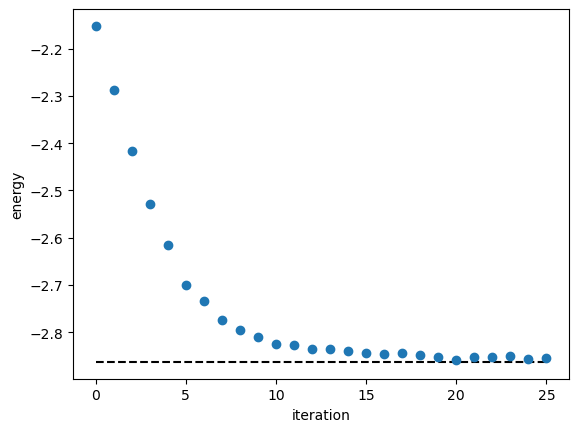

In [11]:
print(f"angles: {theta}")
# plot the results!
plt.plot([0,iterations],[exactEnergy(),exactEnergy()],'--',color='k')
plt.plot(energy_list,'o')
plt.ylabel('energy')
plt.xlabel('iteration')